In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import (
    MobileNetV2,
    EfficientNetB0,
    ResNet50
)
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import ConvNeXtTiny
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter
from tensorflow.keras.models import load_model

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/drowsiness.zip"
extract_path = "/content/drowsiness_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted!")


Extracted!


In [ ]:
!ls "/content/drowsiness_dataset/Driver Drowsiness Dataset (DDD)"

 Drowsy  'Non Drowsy'


Dividing Data into (train,val,test) folders


In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

data_dir = "/content/drowsiness_dataset/Driver Drowsiness Dataset (DDD)"
output_dir = "/content/splitted_Data"

splitfolders.ratio(
    data_dir,
    output=output_dir,
    seed=1337,
    ratio=(0.8, 0.15, 0.05)  # train, validation, test
)


Copying files: 41793 files [00:46, 907.94 files/s] 


Reading Data (train,test,val)

In [ ]:
train_dir = "/content/splitted_Data/train"
val_dir   = "/content/splitted_Data/val"
test_dir  = "/content/splitted_Data/test"

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7,1.3],
    zoom_range=0.1,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

Flow images from directories

In [ ]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.


In [ ]:
test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=False
)

Found 2091 images belonging to 2 classes.


In [ ]:
val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 6268 images belonging to 2 classes.


Verify a few things(preprocessing).

In [ ]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({np.int32(0): 17878, np.int32(1): 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({np.int32(0): 1118, np.int32(1): 973})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({np.int32(0): 3352, np.int32(1): 2916})


check Normalisation

Pixels of the first image after Normalization: 

[[[0.28627452 0.21960786 0.10980393]
  [0.2901961  0.227451   0.1137255 ]
  [0.3019608  0.2392157  0.12156864]
  ...
  [0.16078432 0.10588236 0.06666667]
  [0.18431373 0.12156864 0.0627451 ]
  [0.20392159 0.12941177 0.06666667]]

 [[0.3254902  0.2627451  0.14509805]
  [0.32941177 0.26666668 0.14509805]
  [0.32941177 0.26666668 0.14509805]
  ...
  [0.16078432 0.10588236 0.06666667]
  [0.17254902 0.10980393 0.05490196]
  [0.19215688 0.12156864 0.0627451 ]]

 [[0.3372549  0.26666668 0.14117648]
  [0.3372549  0.26666668 0.14117648]
  [0.3372549  0.26666668 0.14117648]
  ...
  [0.15294118 0.10196079 0.06666667]
  [0.16862746 0.10588236 0.05490196]
  [0.19215688 0.12156864 0.0627451 ]]

 ...

 [[0.454902   0.3372549  0.24313727]
  [0.454902   0.3372549  0.24313727]
  [0.454902   0.3372549  0.24313727]
  ...
  [0.81568635 0.7019608  0.6313726 ]
  [0.8352942  0.7019608  0.63529414]
  [0.8470589  0.7137255  0.6431373 ]]

 [[0.454902   0.3372549  

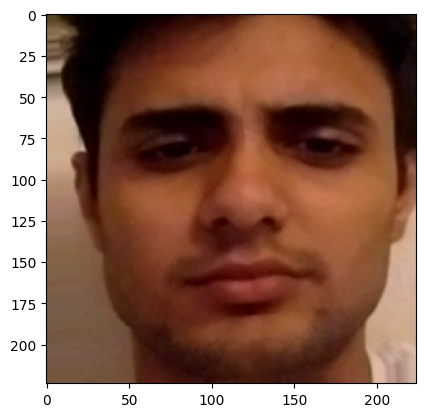

In [ ]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

check channels (RGB),imgs' shapes

In [ ]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


Display the first 45 training images

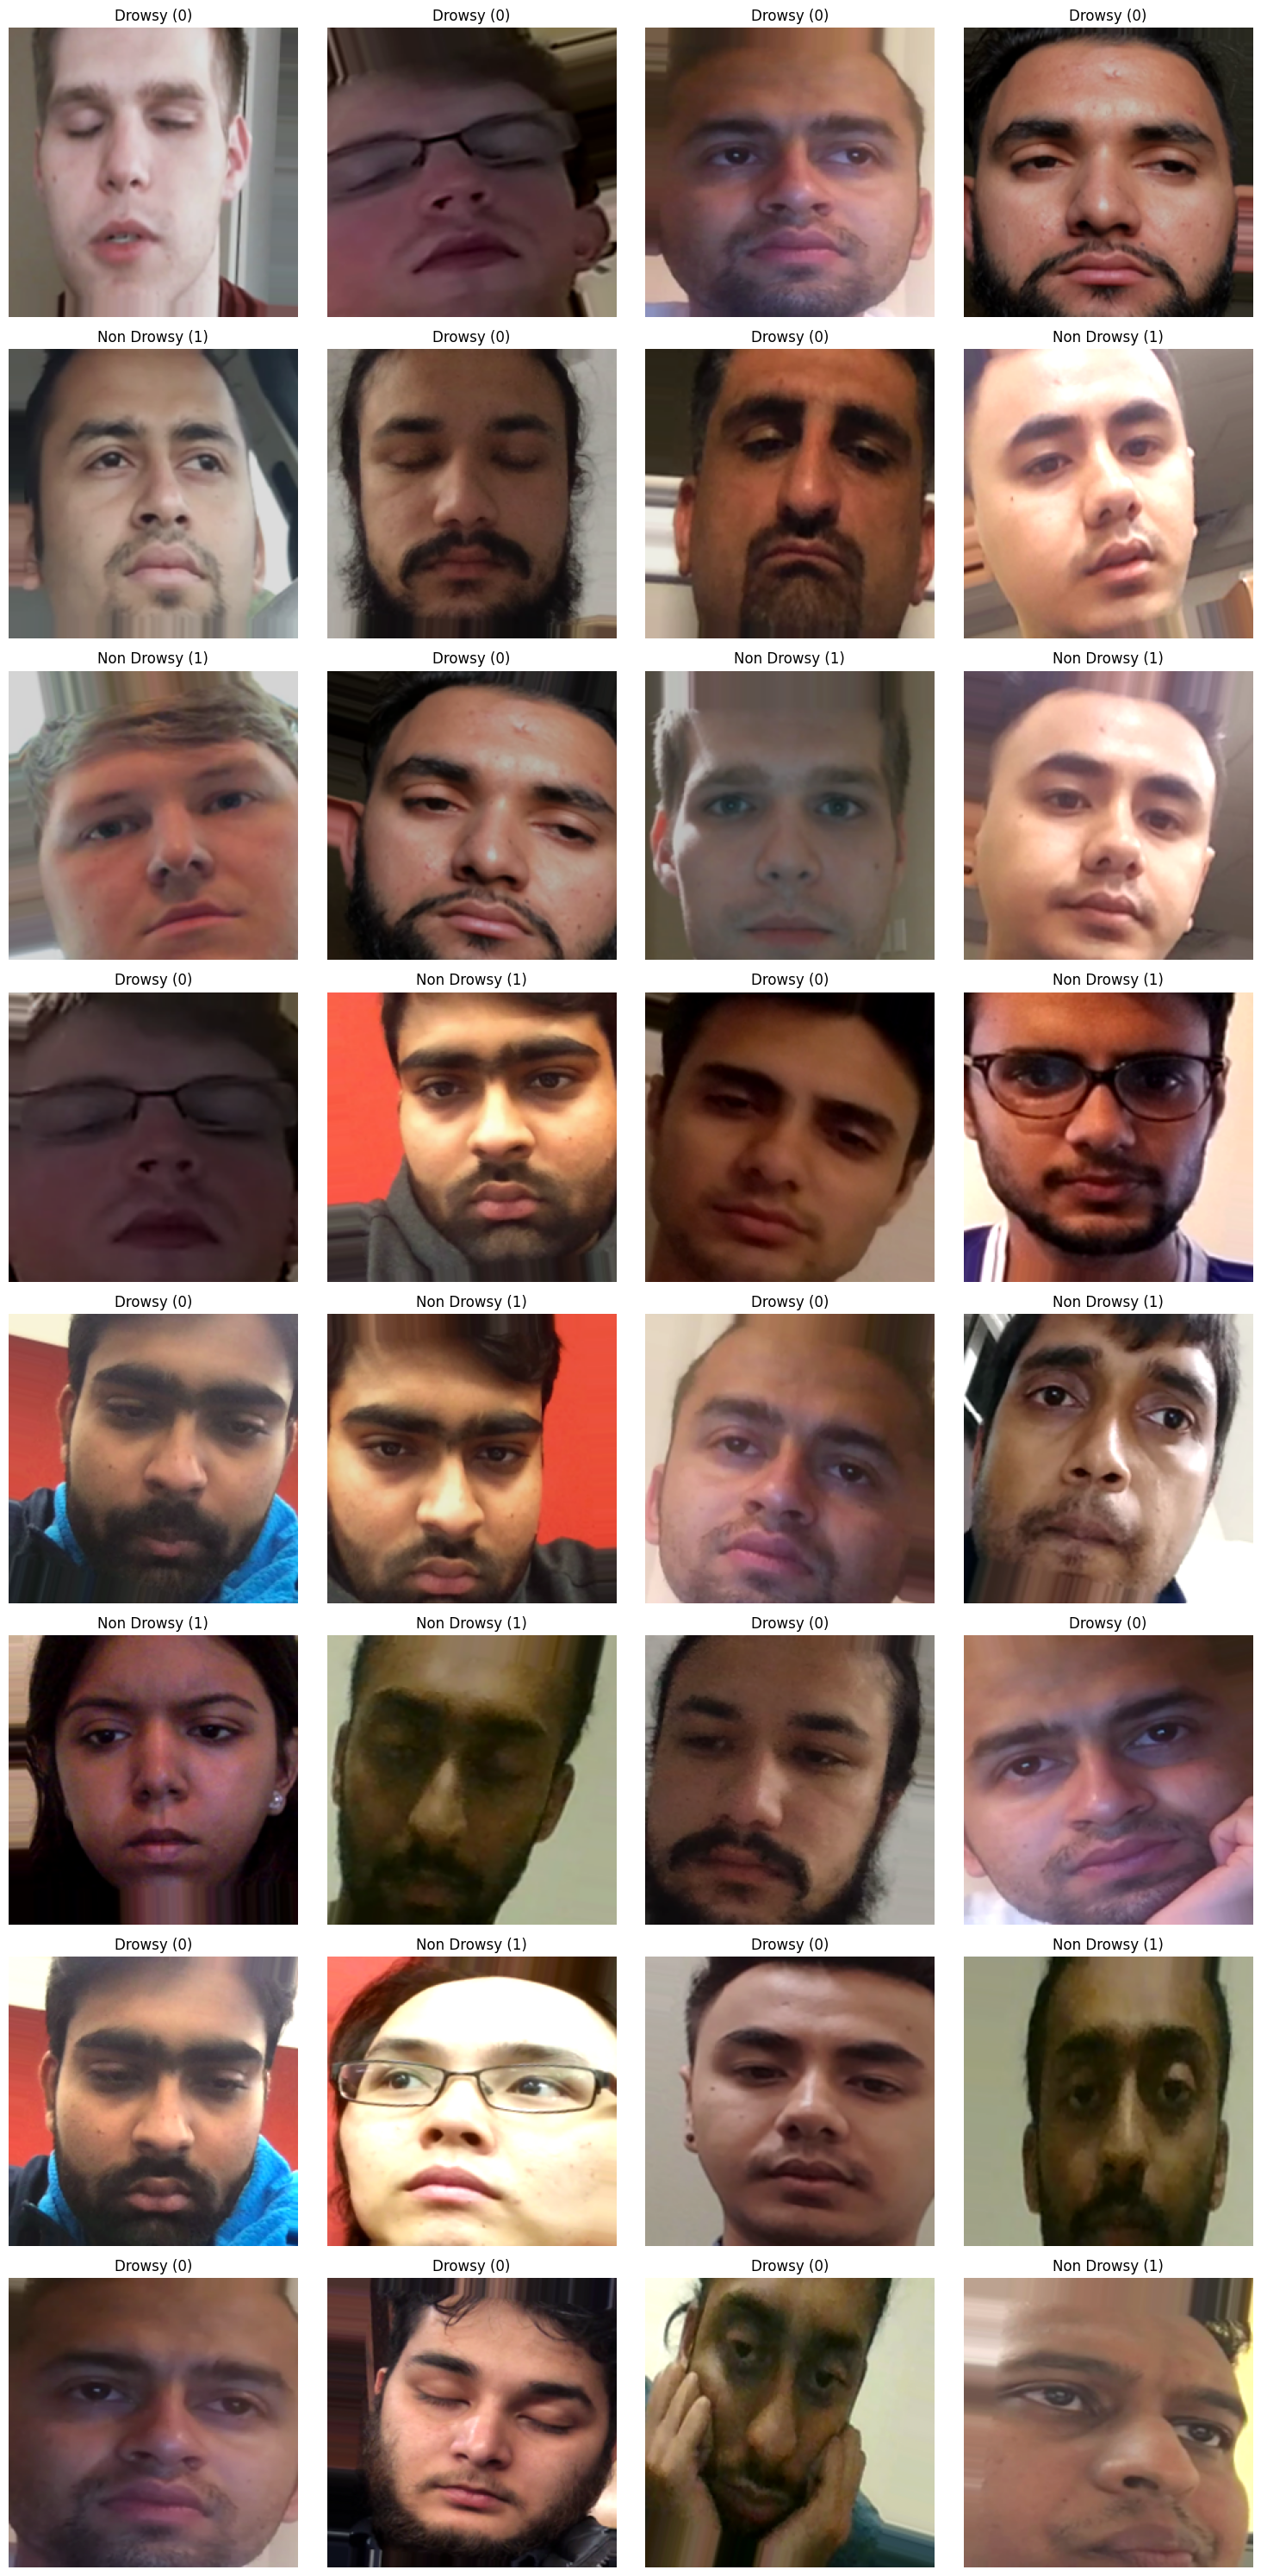

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [ ]:
# ==========================
# Helper Functions
# ==========================

def build_model(base_model, num_classes=1):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  #reduce parameter
    x = Dropout(0.3)(x) #reduce overfitting
    output = Dense(num_classes, activation='sigmoid')(x) #add final prediction layer

    model = Model(inputs=base_model.input, outputs=output) #new top layer to base model
    return model


def train_and_evaluate(model, model_name, epochs=5):
    print("\n\n============================")
    print(f"Training: {model_name}")
    print("============================\n")

    model.compile(
        optimizer=Adam(learning_rate=1e-4),      #update weights
        loss='binary_crossentropy',              #2 class problems
        metrics=['accuracy']
    )
    #train
    history = model.fit(
        train_batches,
        epochs=epochs,
        validation_data=val_batches
    )

    print("\nEvaluating on Test Set ...\n")
    preds = model.predict(test_batches)     #makes predictions on unseen test images
    preds = (preds > 0.5).astype(int)       #binary classes

    y_true = test_batches.classes
    y_pred = preds.flatten()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Closed', 'Open']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Closed', 'Open'],
                yticklabels=['Closed', 'Open'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return history


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training: MobileNetV2



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2244s 1s/step - accuracy: 0.6238 - loss: 0.6536 - val_accuracy: 0.8328 - val_loss: 0.4346
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2205s 1s/step - accuracy: 0.8035 - loss: 0.4390 - val_accuracy: 0.8936 - val_loss: 0.3401
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2241s 1s/step - accuracy: 0.8525 - loss: 0.3644 - val_accuracy: 0.9317 - val_loss: 0.2820
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2209s 1s/step - accuracy: 0.8773 - loss: 0.3190 - val_accuracy: 0.9475 - val_loss: 0.2450
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2239s 1s/step - accuracy: 0.8938 - loss: 0.2852 - val_accuracy: 0.9579 - val_loss: 0.2171

Evaluating on Test Set ...

131/131 ━━━━━━━━━━━━━━━━━━━━ 95s 713ms/step

Classification Report:

              precision    recall  f1-score   support

      Closed       0.95      0.96      0.96      1118
        Open       0.95      0.94      0.95       973

    accuracy                           0.95      2091
   macro avg       0.95      

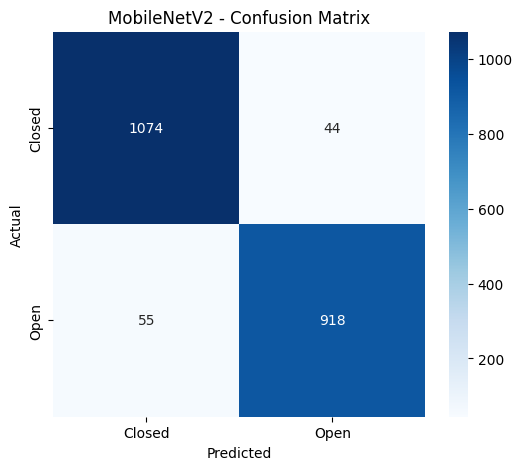

In [ ]:
# ==========================
# Model 1: MobileNetV2
# ==========================

base = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base.trainable = False

model_mobilenet = build_model(base)
history_mobilenet = train_and_evaluate(model_mobilenet, "MobileNetV2", epochs=5)

In [ ]:
# Save model to Drive
model_mobilenet.save("/content/drive/MyDrive/drowsiness_models/mobilenetv2.h5")

model_mobilenet.save('mobilenetv2.keras')

In [ ]:
model_mobilenet = load_model("/content/drive/MyDrive/drowsiness_models/mobilenetv2.h5")



Training: EfficientNetB0

Epoch 1/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3382s 2s/step - accuracy: 0.5092 - loss: 0.6973 - val_accuracy: 0.5348 - val_loss: 0.6917
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3385s 2s/step - accuracy: 0.5168 - loss: 0.6957 - val_accuracy: 0.5348 - val_loss: 0.6907
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3387s 2s/step - accuracy: 0.5256 - loss: 0.6940 - val_accuracy: 0.5348 - val_loss: 0.6910
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3395s 2s/step - accuracy: 0.5245 - loss: 0.6937 - val_accuracy: 0.5348 - val_loss: 0.6906
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3394s 2s/step - accuracy: 0.5207 - loss: 0.6934 - val_accuracy: 0.5348 - val_loss: 0.6908

Evaluating on Test Set ...

131/131 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step

Classification Report:

              precision    recall  f1-score   support

      Closed       0.53      1.00      0.70      1118
        Open       0.00      0.00      0.00       973

    accuracy                           0.53      2091
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


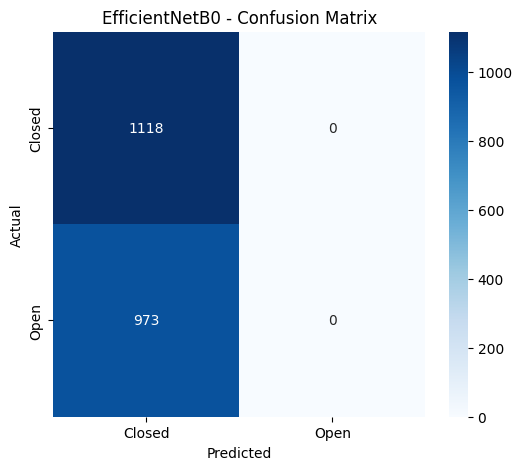

In [ ]:
# ==========================
# Model 2: EfficientNetB0
# ==========================

base = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base.trainable = False

model_efficient = build_model(base)
history_efficient = train_and_evaluate(model_efficient, "EfficientNetB0", epochs=5)



In [ ]:
#save model to Drive
model_convnext.save("/content/drive/MyDrive/drowsiness_models/convnexttiny.h5")
model_convnext.save('/content/drive/MyDrive/drowsiness_models/convnexttiny.keras')

In [ ]:
model_efficient = load_model("/content/drive/MyDrive/drowsiness_models/efficientnetb0.h5")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Training: ResNet50



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 645s 301ms/step - accuracy: 0.5171 - loss: 0.7192 - val_accuracy: 0.5317 - val_loss: 0.6781
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 589s 282ms/step - accuracy: 0.5570 - loss: 0.6857 - val_accuracy: 0.6517 - val_loss: 0.6679
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 574s 275ms/step - accuracy: 0.5805 - loss: 0.6758 - val_accuracy: 0.6490 - val_loss: 0.6603
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 571s 273ms/step - accuracy: 0.5947 - loss: 0.6704 - val_accuracy: 0.6300 - val_loss: 0.6552
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 572s 274ms/step - accuracy: 0.6022 - loss: 0.6675 - val_accuracy: 0.6335 - val_loss: 0.6516

Evaluating on Test Set ...

131/131 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step

Classification Report:

              precision    recall  f1-score   support

      Closed       0.62      0.81      0.70      1118
        Open       0.66      0.43      0.52       973

    accuracy                           0.63      2091
   macro avg       

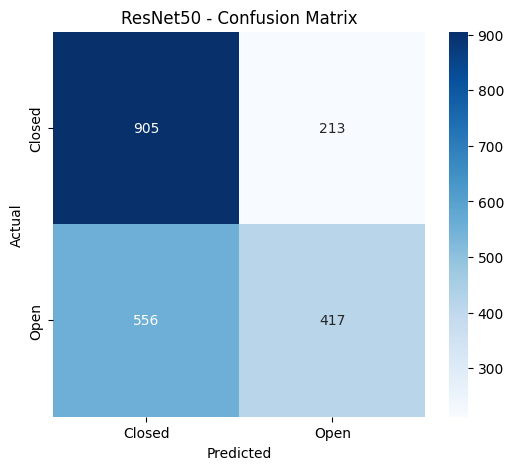

In [ ]:
# ==========================
# Model 3: ResNet50
# ==========================

base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base.trainable = False

model_resnet = build_model(base)
history_resnet = train_and_evaluate(model_resnet, "ResNet50", epochs=5)

In [ ]:
#save model to Drive
model_resnet.save("/content/drive/MyDrive/drowsiness_models/resnet50.h5")

In [ ]:
model_resnet = load_model("/content/drive/MyDrive/drowsiness_models/resnet50.h5")

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Training: ConvNeXtTiny



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 647s 302ms/step - accuracy: 0.5149 - loss: 0.7402 - val_accuracy: 0.6720 - val_loss: 0.6619
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 596s 285ms/step - accuracy: 0.5790 - loss: 0.6757 - val_accuracy: 0.6701 - val_loss: 0.6458
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 598s 286ms/step - accuracy: 0.5982 - loss: 0.6658 - val_accuracy: 0.6859 - val_loss: 0.6384
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 594s 284ms/step - accuracy: 0.6090 - loss: 0.6597 - val_accuracy: 0.6772 - val_loss: 0.6315
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 593s 284ms/step - accuracy: 0.6113 - loss: 0.6567 - val_accuracy: 0.6902 - val_loss: 0.6275

Evaluating on Test Set ...

131/131 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step

Classification Report:

              precision    recall  f1-score   support

      Closed       0.66      0.91      0.76      1118
        Open       0.82      0.45      0.58       973

    accuracy                           0.70      2091
   macro avg       

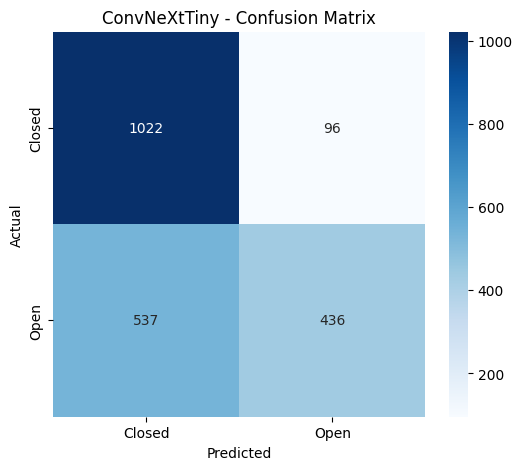

In [ ]:
# ==========================
# Model 4: ConvNeXt-Tiny
# ==========================

base = ConvNeXtTiny(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base.trainable = False

model_convnext = build_model(base)
history_convnext = train_and_evaluate(model_convnext, "ConvNeXtTiny", epochs=5)


In [ ]:
#save model to Drive
model_convnext.save("/content/drive/MyDrive/drowsiness_models/convnexttiny.h5")

In [ ]:
model_convnext = load_model("/content/drive/MyDrive/drowsiness_models/convnexttiny.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Training: DenseNet121



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 683s 313ms/step - accuracy: 0.5369 - loss: 0.7355 - val_accuracy: 0.7214 - val_loss: 0.5779
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 563s 270ms/step - accuracy: 0.6940 - loss: 0.5848 - val_accuracy: 0.8103 - val_loss: 0.5085
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 573s 274ms/step - accuracy: 0.7499 - loss: 0.5253 - val_accuracy: 0.8371 - val_loss: 0.4650
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 551s 264ms/step - accuracy: 0.7777 - loss: 0.4861 - val_accuracy: 0.8660 - val_loss: 0.4318
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 554s 265ms/step - accuracy: 0.7939 - loss: 0.4646 - val_accuracy: 0.8764 - val_loss: 0.4085

Evaluating on Test Set ...

131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 181ms/step

Classification Report:

              precision    recall  f1-score   support

      Closed       0.86      0.94      0.90      1118
        Open       0.92      0.82      0.87       973

    accuracy                           0.89      2091
   macro avg       

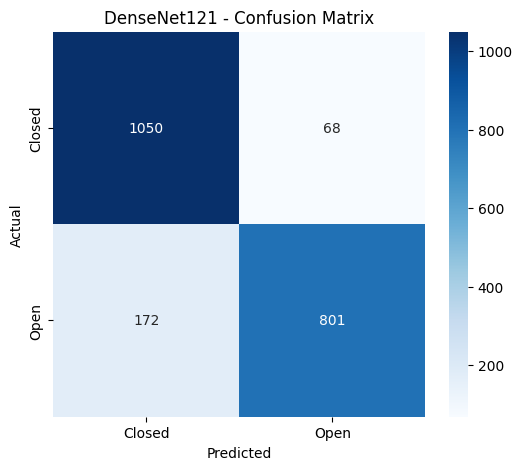

In [ ]:
# ==========================
# Model 5: DenseNet121
# ==========================
base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base.trainable = False

model_densenet = build_model(base)
history_densenet = train_and_evaluate(model_densenet, "DenseNet121", epochs=5)

In [ ]:
model_densenet.save("/content/drive/MyDrive/drowsiness_models/densenet121.h5")

In [ ]:
model_densenet = load_model("/content/drive/MyDrive/drowsiness_models/densenet121.h5")

Comparsions

In [ ]:
save_dir = "/content/drive/MyDrive/drowsiness_models"

model_mobilenet = load_model(f"{save_dir}/mobilenetv2.h5")
model_efficient = load_model(f"{save_dir}/efficientnetb0.h5")
model_resnet = load_model(f"{save_dir}/resnet50.h5")
# Load ConvNeXtTiny model from the native Keras format (.keras) to avoid 'Unknown layer' error
model_convnext = load_model(f"{save_dir}/convnexttiny.keras")
model_densenet=load_model(f"{save_dir}/densenet121.h5")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

models = {
    "MobileNetV2": model_mobilenet,
    "EfficientNetB0": model_efficient,
    "ResNet50": model_resnet,
    "ConvNeXtTiny": model_convnext,
    "DenseNet121" : model_densenet
}

results = []

for name, model in models.items():
    test_batches.reset()
    preds = (model.predict(test_batches) > 0.5).astype(int).flatten()
    y_true = test_batches.classes

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds)
    rec = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)

    print(f"\n{name} Metrics:")
    print(classification_report(y_true, preds, target_names=['Closed','Open']))

    results.append([name, acc, prec, rec, f1])


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 667ms/step

MobileNetV2 Metrics:
              precision    recall  f1-score   support

      Closed       0.95      0.96      0.96      1118
        Open       0.95      0.94      0.95       973

    accuracy                           0.95      2091
   macro avg       0.95      0.95      0.95      2091
weighted avg       0.95      0.95      0.95      2091

131/131 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step

EfficientNetB0 Metrics:
              precision    recall  f1-score   support

      Closed       0.53      1.00      0.70      1118
        Open       0.00      0.00      0.00       973

    accuracy                           0.53      2091
   macro avg       0.27      0.50      0.35      2091
weighted avg       0.29      0.53      0.37      2091



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

131/131 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step

ResNet50 Metrics:
              precision    recall  f1-score   support

      Closed       0.62      0.81      0.70      1118
        Open       0.66      0.43      0.52       973

    accuracy                           0.63      2091
   macro avg       0.64      0.62      0.61      2091
weighted avg       0.64      0.63      0.62      2091

131/131 ━━━━━━━━━━━━━━━━━━━━ 3104s 24s/step

ConvNeXtTiny Metrics:
              precision    recall  f1-score   support

      Closed       0.66      0.91      0.76      1118
        Open       0.82      0.45      0.58       973

    accuracy                           0.70      2091
   macro avg       0.74      0.68      0.67      2091
weighted avg       0.73      0.70      0.68      2091

131/131 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step

DenseNet121 Metrics:
              precision    recall  f1-score   support

      Closed       0.86      0.94      0.90      1118
        Open       0.92      0.82      0.87  

In [ ]:
import pandas as pd

df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1 Score'])
df = df.sort_values(by='Accuracy', ascending=False)

print("\n===== MODEL PERFORMANCE COMPARISON =====\n")
print(df)



===== MODEL PERFORMANCE COMPARISON =====

            Model  Accuracy  Precision    Recall  F1 Score
0     MobileNetV2  0.952654   0.954262  0.943474  0.948837
4     DenseNet121  0.885222   0.921749  0.823227  0.869707
3    ConvNeXtTiny  0.697274   0.819549  0.448099  0.579402
2        ResNet50  0.632233   0.661905  0.428571  0.520274
1  EfficientNetB0  0.534672   0.000000  0.000000  0.000000


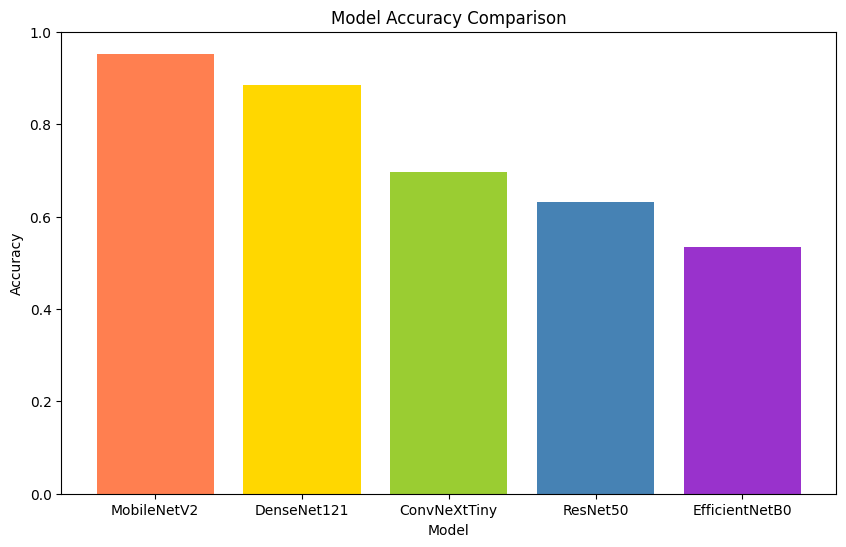

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(df['Model'], df['Accuracy'], color=['coral','gold','yellowgreen','steelblue','darkorchid'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.show()

**Best Model**

In [ ]:
best_model_name = df.iloc[0]['Model']
print(f"Best Model: {best_model_name}")

if best_model_name == "MobileNetV2":
    best_model = model_mobilenet
elif best_model_name == "EfficientNetB0":
    best_model = model_efficient
elif best_model_name == "ResNet50":
    best_model = model_resnet
elif best_model_name == "ConvNeXtTiny":
    best_model = model_convnext
else:
    best_model = model_densenet


Best Model: MobileNetV2


131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 669ms/step


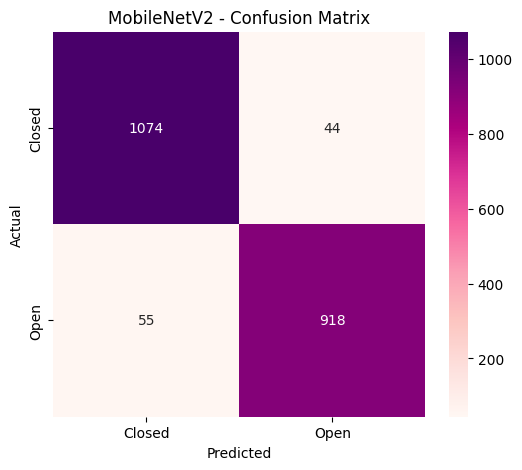

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_batches.reset()
preds = (best_model.predict(test_batches) > 0.5).astype(int).flatten()
y_true = test_batches.classes

cm = confusion_matrix(y_true, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu',
            xticklabels=['Closed','Open'],
            yticklabels=['Closed','Open'])
plt.title(f"{best_model_name} - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
best_model.save(f"{save_dir}/{best_model_name}_FinalBestModel.h5")
print(f"Final best model saved as: {best_model_name}_FinalBestModel.h5")

Final best model saved as: MobileNetV2_FinalBestModel.h5


Ensemble Approach

In [ ]:
# Reset the generator if using ImageDataGenerator
test_batches.reset()

pred_mobilenet = model_mobilenet.predict(test_batches, verbose=1)
pred_efficientnet = model_efficient.predict(test_batches, verbose=1)
pred_resnet = model_resnet.predict(test_batches, verbose=1)
pred_convnext = model_convnext.predict(test_batches, verbose=1)
pred_densenet = model_densenet.predict(test_batches, verbose=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 662ms/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 3116s 24s/step
131/131 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step


In [ ]:
# Assign model weights based on their performance
w1, w2, w3, w4, w5 = 0.15, 0.2, 0.15, 0.25, 0.25

# Weighted average ensemble prediction
ensemble_pred = (w1*pred_mobilenet + w2*pred_efficientnet +
                 w3*pred_resnet + w4*pred_convnext + w5*pred_densenet)

# Convert probabilities to binary class (0 = Alert, 1 = Drowsy)
final_pred = (ensemble_pred > 0.5).astype(int)


Ensemble Model Accuracy: 92.73%

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.93      1118
           1       0.96      0.88      0.92       973

    accuracy                           0.93      2091
   macro avg       0.93      0.92      0.93      2091
weighted avg       0.93      0.93      0.93      2091



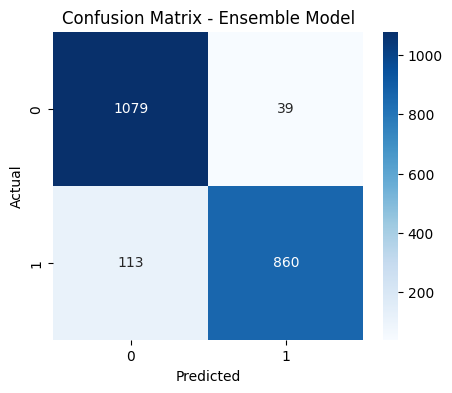

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_batches.classes  # actual labels from generator

acc = accuracy_score(y_true, final_pred)
print(f"Ensemble Model Accuracy: {acc*100:.2f}%\n")

print("Classification Report:\n", classification_report(y_true, final_pred))

# Confusion matrix
cm = confusion_matrix(y_true, final_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

Fine tuning

In [ ]:
import os

# Define the directory path
save_ensemble_dir = '/content/drive/MyDrive/models'

# Create the directory if it doesn't exist
os.makedirs(save_ensemble_dir, exist_ok=True)

# Save the ensemble predictions
np.save(f'{save_ensemble_dir}/ensemble_predictions.npy', final_pred)

In [ ]:
pip install opencv-python tensorflow


In [ ]:
model = load_model(f"{save_dir}/MobileNetV2_FinalBestModel.h5")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/drowsiness_models/MobileNetV2_FinalBestModel.h5")


In [ ]:
# Assuming 'model' is the loaded combined model (MobileNetV2 + custom head)

# The error 'Conv2D' object has no attribute 'layers' suggests that the MobileNetV2
# base model is not nested as a single layer within 'model.layers', but rather
# its individual layers are flattened directly into 'model.layers'.

# We need to find the layers corresponding to the MobileNetV2 part.
# The custom head layers are GlobalAveragePooling2D, Dropout, and Dense.
# These typically appear at the end of the model's layers list.

# Let's identify the index where the custom head layers begin.
# We'll search for the GlobalAveragePooling2D layer, which is the first layer of the custom head.
global_avg_pool_layer_index = -1
for i, layer in enumerate(model.layers):
    if isinstance(layer, GlobalAveragePooling2D):
        global_avg_pool_layer_index = i
        break

if global_avg_pool_layer_index != -1:
    # Layers from index 1 up to (but not including) global_avg_pool_layer_index are the MobileNetV2 base layers.
    # The InputLayer (index 0) should remain frozen.

    # Freeze all layers of the base model initially, except for the input layer (index 0).
    # This includes the part of MobileNetV2 that we don't want to fine-tune.
    for layer in model.layers[1:global_avg_pool_layer_index]:
        layer.trainable = False

    # Now, unfreeze the last 30 layers of the MobileNetV2 base.
    # These are the layers from (global_avg_pool_layer_index - 30) up to (global_avg_pool_layer_index).
    # Ensure we don't go below index 1 (after the InputLayer).
    layers_to_unfreeze_start_idx = max(1, global_avg_pool_layer_index - 30)

    for layer in model.layers[layers_to_unfreeze_start_idx : global_avg_pool_layer_index]:
        layer.trainable = True

    # Ensure the custom head layers (GlobalAveragePooling2D, Dropout, and Dense) are trainable.
    # These were implicitly trainable when the model was trained by `train_and_evaluate`.
    for layer in model.layers[global_avg_pool_layer_index:]:
        layer.trainable = True

    print(f"Fine-tuning setup complete: ")
    print(f"  - Frozen layers: model.layers[1:{layers_to_unfreeze_start_idx}]")
    print(f"  - Unfrozen MobileNetV2 layers: model.layers[{layers_to_unfreeze_start_idx}:{global_avg_pool_layer_index}]")
    print(f"  - Unfrozen Custom Head layers: model.layers[{global_avg_pool_layer_index}:]")

else:
    print("Error: Could not find the GlobalAveragePooling2D layer in the model. Fine-tuning setup failed.")
    print("Please inspect the model's architecture (e.g., model.summary()) to understand its layer structure.")

# Optional: Print trainable status of layers to verify
print("\nTrainable status of relevant layers:")
for i, layer in enumerate(model.layers):
    if layer.trainable:
        print(f"  - Layer {i}: {layer.name} (Trainable: {layer.trainable})")


Fine-tuning setup complete: 
  - Frozen layers: model.layers[1:124]
  - Unfrozen MobileNetV2 layers: model.layers[124:154]
  - Unfrozen Custom Head layers: model.layers[154:]

Trainable status of relevant layers:
  - Layer 0: input_layer (Trainable: True)
  - Layer 124: block_13_project_BN (Trainable: True)
  - Layer 125: block_14_expand (Trainable: True)
  - Layer 126: block_14_expand_BN (Trainable: True)
  - Layer 127: block_14_expand_relu (Trainable: True)
  - Layer 128: block_14_depthwise (Trainable: True)
  - Layer 129: block_14_depthwise_BN (Trainable: True)
  - Layer 130: block_14_depthwise_relu (Trainable: True)
  - Layer 131: block_14_project (Trainable: True)
  - Layer 132: block_14_project_BN (Trainable: True)
  - Layer 133: block_14_add (Trainable: True)
  - Layer 134: block_15_expand (Trainable: True)
  - Layer 135: block_15_expand_BN (Trainable: True)
  - Layer 136: block_15_expand_relu (Trainable: True)
  - Layer 137: block_15_depthwise (Trainable: True)
  - Layer 138: b

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),   # small LR for stable fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.3, patience=2)
]

history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=5,                  # small number — you’re fine-tuning, not full training
    # class_weight=class_weights,  # optional but helpful if data is imbalanced
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2605s 1s/step - accuracy: 0.8840 - loss: 0.2744 - val_accuracy: 0.9974 - val_loss: 0.0135 - learning_rate: 1.0000e-05
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2579s 1s/step - accuracy: 0.9863 - loss: 0.0417 - val_accuracy: 0.9995 - val_loss: 0.0031 - learning_rate: 1.0000e-05
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2588s 1s/step - accuracy: 0.9917 - loss: 0.0236 - val_accuracy: 0.9994 - val_loss: 0.0022 - learning_rate: 1.0000e-05
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2622s 1s/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.9994 - val_loss: 0.0028 - learning_rate: 1.0000e-05
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2690s 1s/step - accuracy: 0.9962 - loss: 0.0115 - val_accuracy: 0.9997 - val_loss: 9.9160e-04 - learning_rate: 1.0000e-05


In [ ]:
model.save("/content/drive/MyDrive/drowsiness_models/MobileNetV2_FineTuned.h5")


**opencv**

<IPython.core.display.Javascript object>

✅ Image captured!
Raw prediction: 0.285 → Drowsy


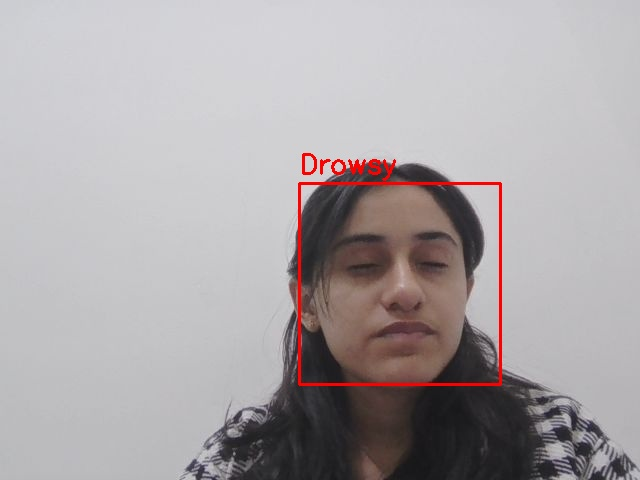

🛑 Detection complete.


In [ ]:
# === Step 1: Imports ===
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from IPython.display import display, Javascript, Image, Audio
from google.colab.output import eval_js
from base64 import b64decode
from collections import deque

# === Step 2: Function to capture image from webcam (Colab-compatible) ===
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = '📸 Capture';
      div.appendChild(capture);
      document.body.appendChild(div);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Wait for capture button
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(t => t.stop());
      video.remove(); div.remove();
      const dataUrl = canvas.toDataURL('image/jpeg', quality);
      return dataUrl;
    }
    ''')
    display(js)
    # The error 'NotAllowedError: Permission denied' means webcam access was denied by the browser.
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# === Step 3: Function to play beep sound (Colab compatible) ===
def play_beep_sound(frequency=1000, duration=0.7, volume=0.5):
    samplerate = 44100  # Hz
    t = np.linspace(0, duration, int(samplerate * duration), False)
    data = volume * np.sin(2 * np.pi * frequency * t)
    display(Audio(data, rate=samplerate, autoplay=True))

# === Step 4: Load trained model ===
save_dir = "/content/drive/MyDrive/drowsiness_models"  # Adjust if needed
model = load_model(f"{save_dir}/MobileNetV2_FinalBestModel.h5")

# === Step 5: Capture frame and run prediction ===
filename = take_photo()
print("✅ Image captured!")

# Read and process the image
frame = cv2.imread(filename)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

alert_history = deque(maxlen=10)

for (x, y, w, h) in faces:
    # Crop the face region
    face = frame[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    face = face / 255.0  # ✅ scale to [0,1] (since you used rescale=1./255 during training)
    face = np.expand_dims(face, axis=0)

    preds = model.predict(face, verbose=0)

    # Binary classification: 0 = Drowsy, 1 = Awake
    # Use a slightly lower threshold for sensitivity
    threshold = 0.4
    if preds[0][0] >= threshold:
      label = "Awake"
    else:
      label = "Drowsy"
    print(f"Raw prediction: {preds[0][0]:.3f} → {label}")


    color = (0, 255, 0) if label == "Awake" else (0, 0, 255)
    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
    cv2.putText(frame, label, (x, y-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Beep if drowsy for multiple frames
    if label == "Drowsy":
        alert_history.append(1)
    else:
        alert_history.append(0)

    if sum(alert_history) > 7:
        play_beep_sound(1000, 0.7, 0.5)

# Display the annotated result
_, im_arr = cv2.imencode('.jpg', frame)
display(Image(data=im_arr))
print("🛑 Detection complete.")
